In [2]:
# import warnings
# warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pathlib import Path

import torch

from cell import utils
from cell.utils import link_prediction_performance, edge_overlap
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

In [3]:
#train_graph 
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/eps_neighbour_graph.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [4]:
with np.load('../data/eps_neighbour_graph.npz', allow_pickle=True) as loader:
    coos = loader['coos']
    # coos = coos[:, :2]
    coos = coos[lcc, :2]

In [5]:
coos.shape, _A_obs.shape

((184, 2), (184, 184))

In [6]:
print(_N)

184


In [7]:
Gs = dict()
df = pd.DataFrame()

In [8]:
Gs['true'] = _A_obs

In [9]:
val_share = 0.05
test_share = 0.1
seed = 42 #481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, connected=True, undirected=True, asserts=False)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [10]:
def run(g_type='cell', loss_fn=None, criterion='eo', nsteps=200):
    if criterion == 'eo':
        callbacks = [EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)]
    else:
        callbacks = [LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)]
    model = Cell(A=train_graph,
             H=9,
             g_type=g_type,
             loss_fn=loss_fn,
             callbacks=callbacks)

    # train model 
    model.train(steps=nsteps,
                optimizer_fn=torch.optim.Adam,
                optimizer_args={'lr': 0.1,
                                'weight_decay': 1e-5})
    
    roc_auc, avg_prec = link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)
    print(f'ROC-AUC: {roc_auc}, AVG_PREC: {avg_prec}')

    generated_graphs = [model.sample_graph() for _ in range(5)]
    stats = [compute_graph_statistics(gg) for gg in generated_graphs]
    stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})
    stat_df = stat_df.mean()
    stat_df['roc-auc'] = roc_auc
    stat_df['avg-prec'] = avg_prec

    return stat_df.T, generated_graphs

    

In [11]:
method = 'cell'
options = dict(g_type='cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 3.09492 Edge-Overlap: 0.365 Total-Time: 0
Step:  20/200 Loss: 2.04370 Edge-Overlap: 0.784 Total-Time: 0
ROC-AUC: 0.9387682449270203, AVG_PREC: 0.9472062477405101


In [12]:
method = 'local cell'
options = dict(g_type='cell', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 5.99957 Edge-Overlap: 0.381 Total-Time: 0
Step:  20/200 Loss: 3.97528 Edge-Overlap: 0.770 Total-Time: 0
ROC-AUC: 0.9444642221431114, AVG_PREC: 0.9298549032253003


In [13]:
method = 'svd'
options = dict(g_type='svd')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 4.39349 Edge-Overlap: 0.115 Total-Time: 0
Step:  20/200 Loss: 2.61901 Edge-Overlap: 0.734 Total-Time: 0
ROC-AUC: 0.9583481666073336, AVG_PREC: 0.9673897007056467


In [14]:
method = 'local svd'
options = dict(g_type='svd', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 8.43269 Edge-Overlap: 0.119 Total-Time: 0
Step:  20/200 Loss: 4.92058 Edge-Overlap: 0.748 Total-Time: 0
ROC-AUC: 0.9533641865432538, AVG_PREC: 0.9488812443750592


In [15]:
method = 'nonlin cell'
options = dict(g_type='fc')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 3.00877 Edge-Overlap: 0.471 Total-Time: 0
Step:  20/200 Loss: 2.07452 Edge-Overlap: 0.752 Total-Time: 0
ROC-AUC: 0.9611961552153792, AVG_PREC: 0.9673807889069155


In [16]:
method = 'local nonlin cell'
options = dict(g_type='fc', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 6.81944 Edge-Overlap: 0.342 Total-Time: 0
Step:  20/200 Loss: 4.63951 Edge-Overlap: 0.637 Total-Time: 0
ROC-AUC: 0.9601281594873623, AVG_PREC: 0.9629517655390937


In [17]:
df['gt'] = list(compute_graph_statistics(_A_obs).values()) + [1, 1]
df

,cell,local cell,svd,local svd,nonlin cell,local nonlin cell,gt
d_max,10.800000,10.800000,10.800000,12.000000,14.600000,12.000000,11.000000
d_min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
d,4.826087,4.826087,4.826087,4.826087,4.826087,4.826087,5.684783
LCC,183.600000,184.000000,182.800000,184.000000,183.400000,184.000000,184.000000
wedge_count,2085.000000,2024.400000,2067.800000,2103.800000,2296.000000,2150.200000,2914.000000
claw_count,3180.800000,2926.200000,3107.600000,3323.800000,4386.600000,3492.200000,5260.000000
triangle_count,219.600000,211.400000,230.400000,252.000000,267.400000,202.200000,564.000000
square_count,535.200000,468.800000,571.600000,660.800000,812.800000,518.000000,1770.000000
power_law_exp,1.681350,1.673360,1.678651,1.680901,1.700092,1.689943,1.608979
gini,0.236942,0.215577,0.231558,0.240274,0.286185,0.255849,0.222203


No handles with labels found to put in legend.


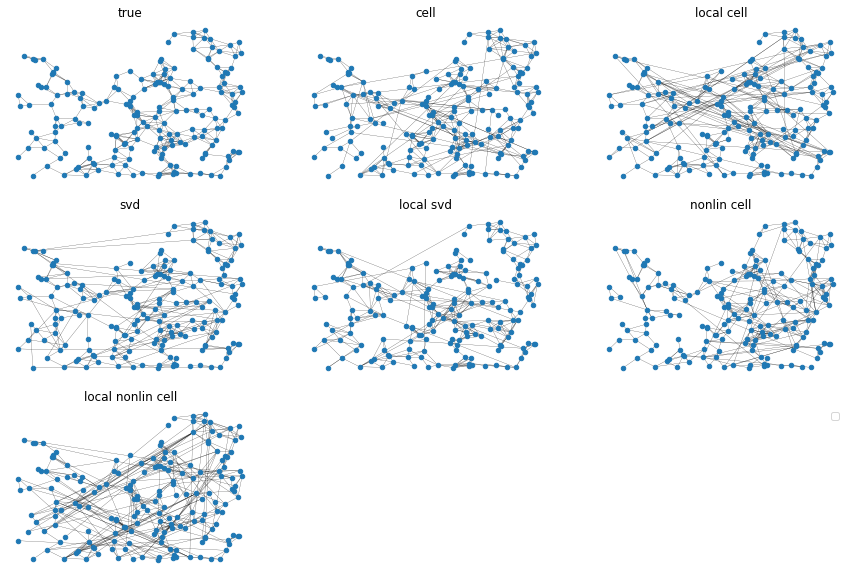

In [18]:
import itertools

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

methods = ['true', 'cell', 'local cell', 'svd', 'local svd', 'nonlin cell', 'local nonlin cell']
for ax, name in zip(itertools.chain.from_iterable(axs), methods):
    G = nx.from_numpy_array(Gs[name].toarray())
    nx.draw(G, node_size=20, width=0.2, pos=coos, ax=ax)
    ax.set_title(name)
for ax in list(itertools.chain.from_iterable(axs))[len(methods):]:
    ax.axis('off')
plt.legend()
plt.savefig('../img/eps_neighbour_graph.png')
plt.show()